## Parallel Computing for 94-class Character Recognition Using Convolutional Neural Network

## Comparing DDP vs AMP Training Performance

Importing Essential Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Data Loading

In [2]:
ddp_metrics_epoch = pd.read_csv("../TMINST_MultiGPUs_DDP/DDP_experiment_metrics_epoch.csv")
ddp_metrics_test = pd.read_csv("../TMINST_MultiGPUs_DDP/DDP_experiment_metrics_test.csv")
amp_metrics_epoch = pd.read_csv("../TMINST_MultiGPUs_AMP/AMP_experiment_metrics_epoch.csv")
amp_metrics_test = pd.read_csv("../TMINST_MultiGPUs_AMP/AMP_experiment_metrics_test.csv")

## Analyzing Training Time Reduction with Mixed Precision

In [5]:
# Select and rename training time columns
ddp_times = ddp_metrics_test[['gpu_count', 'batch_size', 'total_training_time']].rename(
    columns={"total_training_time": "DDP_Training_Time"}
)
amp_times = amp_metrics_test[['gpu_count', 'batch_size', 'total_training_time']].rename(
    columns={"total_training_time": "AMP_Training_Time"}
)

# 🔗 Merge on gpu_count and batch_size
comparison_df = pd.merge(ddp_times, amp_times, on=['gpu_count', 'batch_size'])

# ➗ Calculate percentage time reduction from DDP to AMP
comparison_df['% Time Reduced'] = (
    (comparison_df['DDP_Training_Time'] - comparison_df['AMP_Training_Time']) /
    comparison_df['DDP_Training_Time'] * 100
).round(2)

# 🖨️ Display the sorted result
comparison_df = comparison_df.sort_values(by=['batch_size', 'gpu_count']).reset_index(drop=True)
display(comparison_df)

,gpu_count,batch_size,DDP_Training_Time,AMP_Training_Time,% Time Reduced
0,1,64,166.221044,102.911478,38.09
1,2,64,89.758089,51.986346,42.08
2,3,64,60.312971,37.369506,38.04
3,4,64,45.430460,30.079503,33.79
4,1,128,127.738831,65.372902,48.82
5,2,128,67.792323,34.671821,48.86
6,3,128,44.639975,23.432706,47.51
7,4,128,37.692451,18.714686,50.35
8,1,256,108.184208,47.663923,55.94
9,2,256,59.446196,26.503685,55.42


- **Universal Speedup**: AMP consistently delivers significant training time reductions across all GPU counts and batch sizes
- **Scaling with Batch Size**: Time reduction generally increases with larger batch sizes
  - Batch size 64: ~38-42% reduction
  - Batch size 2048: ~64-66% reduction
- **Most Dramatic Improvements**:
  - 4 GPUs, batch size 2048: 66.25% reduction (31.72s → 10.71s)
  - 1 GPU, batch size 1024: 65.83% reduction (104.31s → 35.64s)
- **Consistent Benefits**: Even the smallest improvement (4 GPUs, batch size 64) still shows a substantial 33.79% reduction

AMP provides significant computational advantages by:
- Reducing memory bandwidth requirements through smaller data types
- Enabling more efficient use of Tensor Cores on modern GPUs
- Maintaining accuracy while dramatically cutting training time

## Comparing DDP and AMP Training times Across GPU and Batch Size Configurations

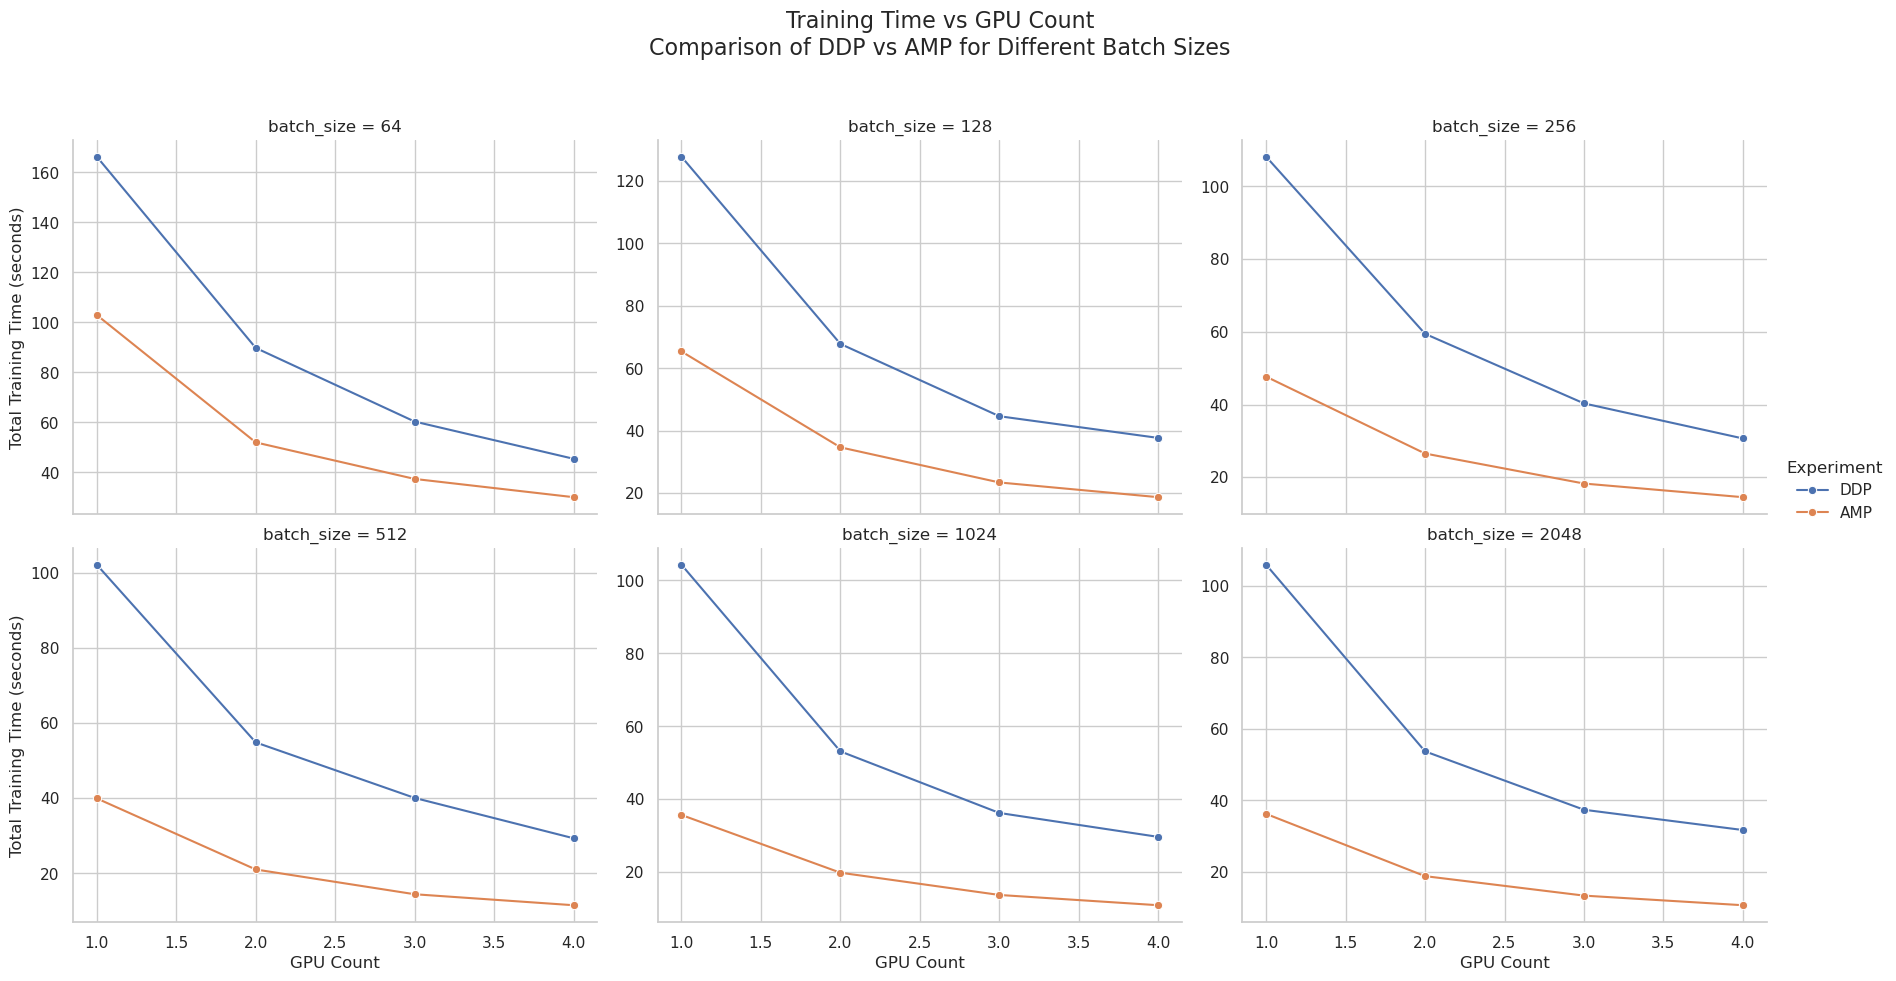

In [6]:
# Add an experiment label
ddp_metrics_test['experiment'] = 'DDP'
amp_metrics_test['experiment'] = 'AMP'

# Combine both into a single DataFrame
combined_df = pd.concat([ddp_metrics_test, amp_metrics_test], ignore_index=True)

# Make sure numeric columns are correctly typed (if needed)
combined_df['gpu_count'] = pd.to_numeric(combined_df['gpu_count'])
combined_df['batch_size'] = pd.to_numeric(combined_df['batch_size'])
combined_df['total_training_time'] = pd.to_numeric(combined_df['total_training_time'])

# Set Seaborn style
sns.set(style="whitegrid")

# Create FacetGrid with 3 columns
g = sns.FacetGrid(
    data=combined_df,
    col="batch_size",
    hue="experiment",
    col_wrap=3,
    height=5,
    aspect=1.2,
    sharey=False
)
# Map lineplot to the grid
g.map(sns.lineplot, "gpu_count", "total_training_time", marker="o")

# Add plot titles and labels
g.set_axis_labels("GPU Count", "Total Training Time (seconds)")
g.add_legend(title="Experiment")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Training Time vs GPU Count\nComparison of DDP vs AMP for Different Batch Sizes", fontsize=16)

# Display the plot
plt.show()

### Key Insights Across All Batch Sizes:

- **Consistent Performance Gap**: AMP provides substantial speedups across all configurations, with the orange line consistently well below the blue DDP line
- **Parallel Scaling Patterns**: Both techniques show similar scaling behavior as GPU count increases, but AMP maintains its advantage throughout
- **Convergence at Higher GPU Counts**: The relative advantage of AMP remains significant even at 4 GPUs

### Batch Size-Specific Observations:

- **Small Batch Sizes (64, 128)**: 
  - Show the largest absolute time reductions with AMP
  - For batch size 64, AMP with 1 GPU (102s) outperforms DDP with 2 GPUs (90s)

- **Medium Batch Sizes (256, 512)**:
  - Demonstrate the most dramatic percentage improvements
  - For batch size 512, AMP with 1 GPU (40s) matches DDP with 3 GPUs (40s)

- **Large Batch Sizes (1024, 2048)**:
  - Maintain significant advantages even with highest parallelism
  - For batch size 2048, AMP with 2 GPUs (19s) outperforms DDP with 4 GPUs (32s)

## Test Accuracy Comparison: DDP vs AMP

In [7]:
# 🎯 Select and rename test accuracy columns
ddp_acc = ddp_metrics_test[['gpu_count', 'batch_size', 'test_acc']].rename(columns={'test_acc': 'DDP_Test_Acc'})
amp_acc = amp_metrics_test[['gpu_count', 'batch_size', 'test_acc']].rename(columns={'test_acc': 'AMP_Test_Acc'})

# 🔗 Merge on GPU count and batch size
acc_comparison_df = pd.merge(ddp_acc, amp_acc, on=['gpu_count', 'batch_size'])

# 🎯 Convert to percentages and round
acc_comparison_df['DDP_Test_Acc'] = (acc_comparison_df['DDP_Test_Acc'] * 100).round(2)
acc_comparison_df['AMP_Test_Acc'] = (acc_comparison_df['AMP_Test_Acc'] * 100).round(2)

# 🖨️ Display test accuracy comparison
print("Test Accuracy Comparison (in %):")
display(acc_comparison_df)

Test Accuracy Comparison (in %):


,gpu_count,batch_size,DDP_Test_Acc,AMP_Test_Acc
0,1,64,93.20,93.19
1,2,64,93.04,93.09
2,3,64,93.25,93.07
3,4,64,93.25,93.16
4,1,128,93.14,93.35
5,2,128,92.96,93.26
6,3,128,92.94,93.10
7,4,128,92.89,93.01
8,1,256,93.15,93.09
9,2,256,92.84,92.85


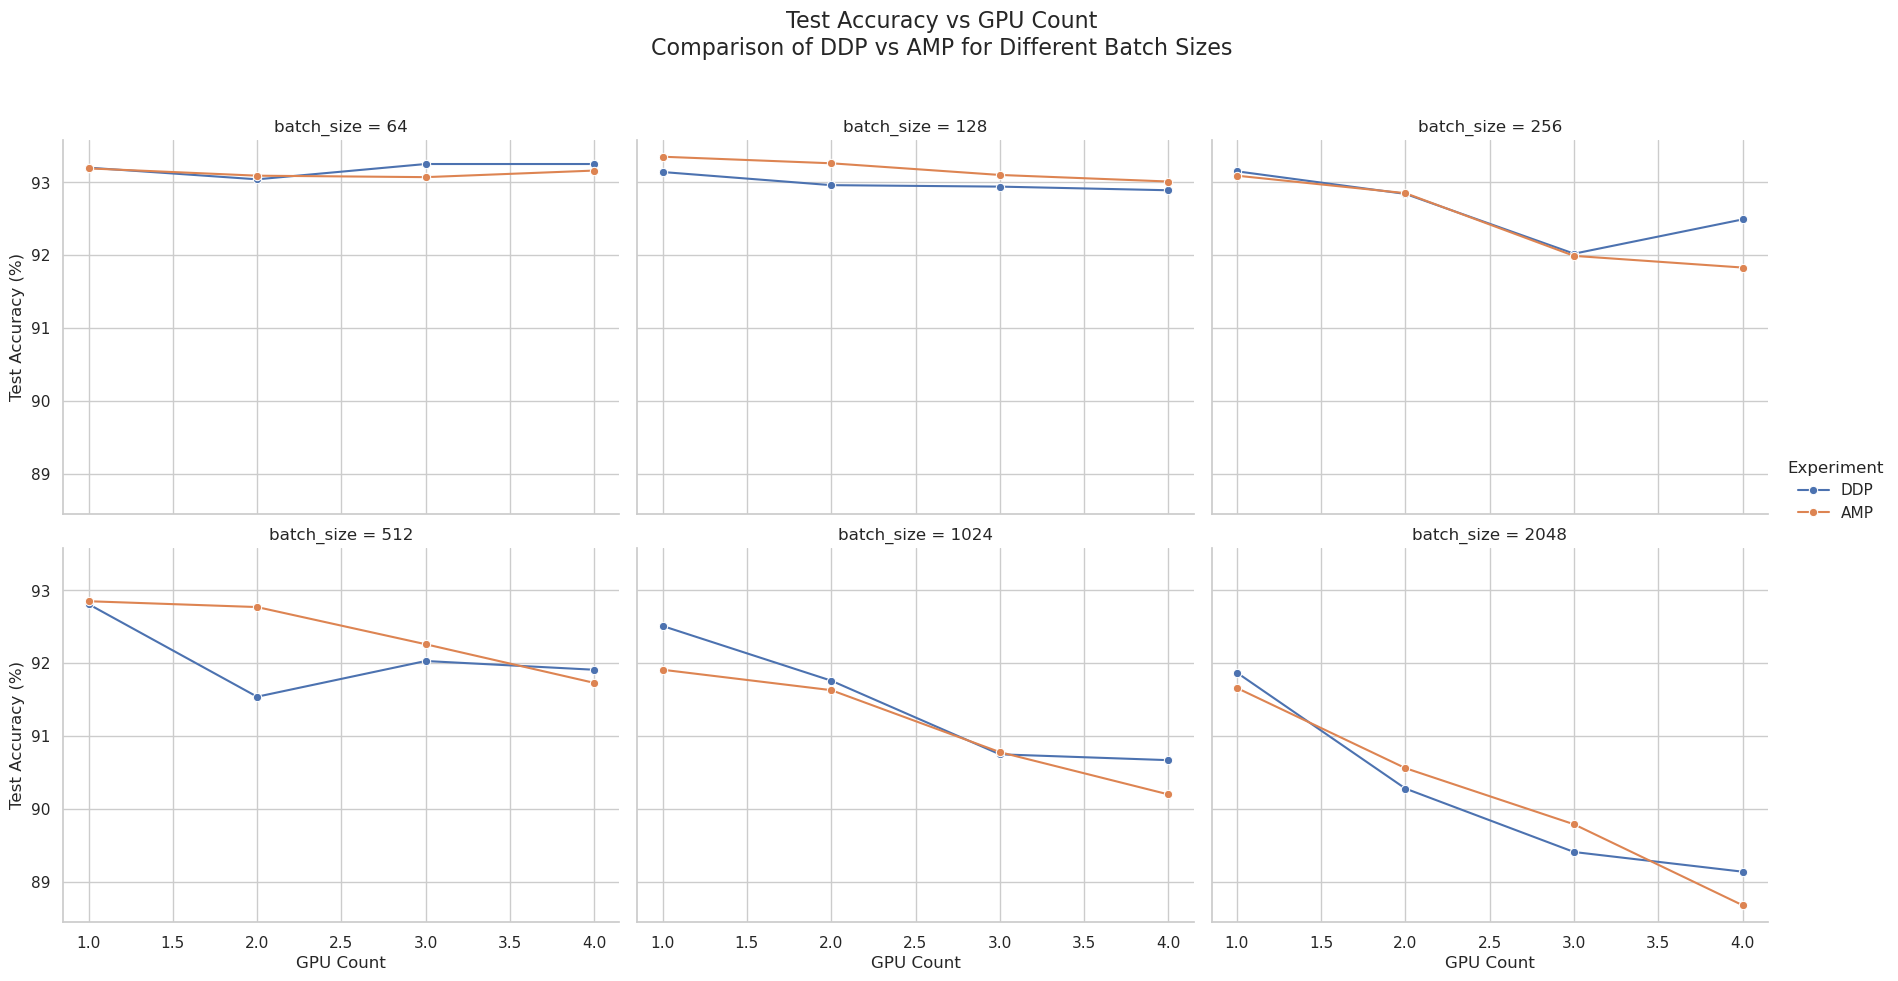

In [8]:
# Convert test accuracy to percentage
combined_df['test_acc_percent'] = (combined_df['test_acc'] * 100).round(2)

# Seaborn FacetGrid plot with 3 columns
sns.set(style="whitegrid")
g = sns.FacetGrid(
    data=combined_df,
    col="batch_size",
    hue="experiment",
    col_wrap=3,
    height=5,
    aspect=1.2,
    sharey=True  #You can also set to False if you want y-scales per plot
)

# Plot test accuracy
g.map(sns.lineplot, "gpu_count", "test_acc_percent", marker="o")

# Customize axes and title
g.set_axis_labels("GPU Count", "Test Accuracy (%)")
g.add_legend(title="Experiment")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Test Accuracy vs GPU Count\nComparison of DDP vs AMP for Different Batch Sizes", fontsize=16)

# Show plot
plt.show()

1. **Small Batch Sizes (64-128)**:
   - Both methods achieve excellent accuracy (>93%)
   - AMP performs surprisingly well, sometimes exceeding DDP accuracy
   - Batch size 128 with 1 GPU using AMP achieves the highest overall accuracy (93.35%)

2. **Medium Batch Sizes (256-512)**:
   - Both methods maintain good accuracy (>91.5% for most configurations)
   - Slight accuracy variations between methods, but differences are minimal
   - First signs of accuracy degradation appear at 3-4 GPUs with batch size 512

3. **Large Batch Sizes (1024-2048)**:
   - Both methods show progressive accuracy decline
   - Accuracy drops below 90% for configurations with 3-4 GPUs
   - Largest accuracy difference occurs at batch size 2048 with 4 GPUs (DDP: 89.14% vs AMP: 88.68%)

## Memory Usage Comparison Between DDP and AMP

Memory Used (MB) DDP vs AMP


,gpu_count,batch_size,DDP_Mem_Used_MB,AMP_Mem_Used_MB,DDP_Total_Mem_Used_MB,AMP_Total_Mem_Used_MB
0,1,64,778.37,1838.71,778.37,1838.71
1,1,128,831.96,1838.71,831.96,1838.71
2,1,256,955.01,1884.40,955.01,1884.40
3,1,512,1113.79,1994.98,1113.79,1994.98
4,1,1024,1538.52,2188.32,1538.52,2188.32
5,1,2048,3054.83,2533.95,3054.83,2533.95
6,2,64,540.21,1852.62,1080.42,3705.24
7,2,128,593.80,1852.62,1187.60,3705.24
8,2,256,682.12,1898.31,1364.24,3796.62
9,2,512,875.63,2009.54,1751.26,4019.08


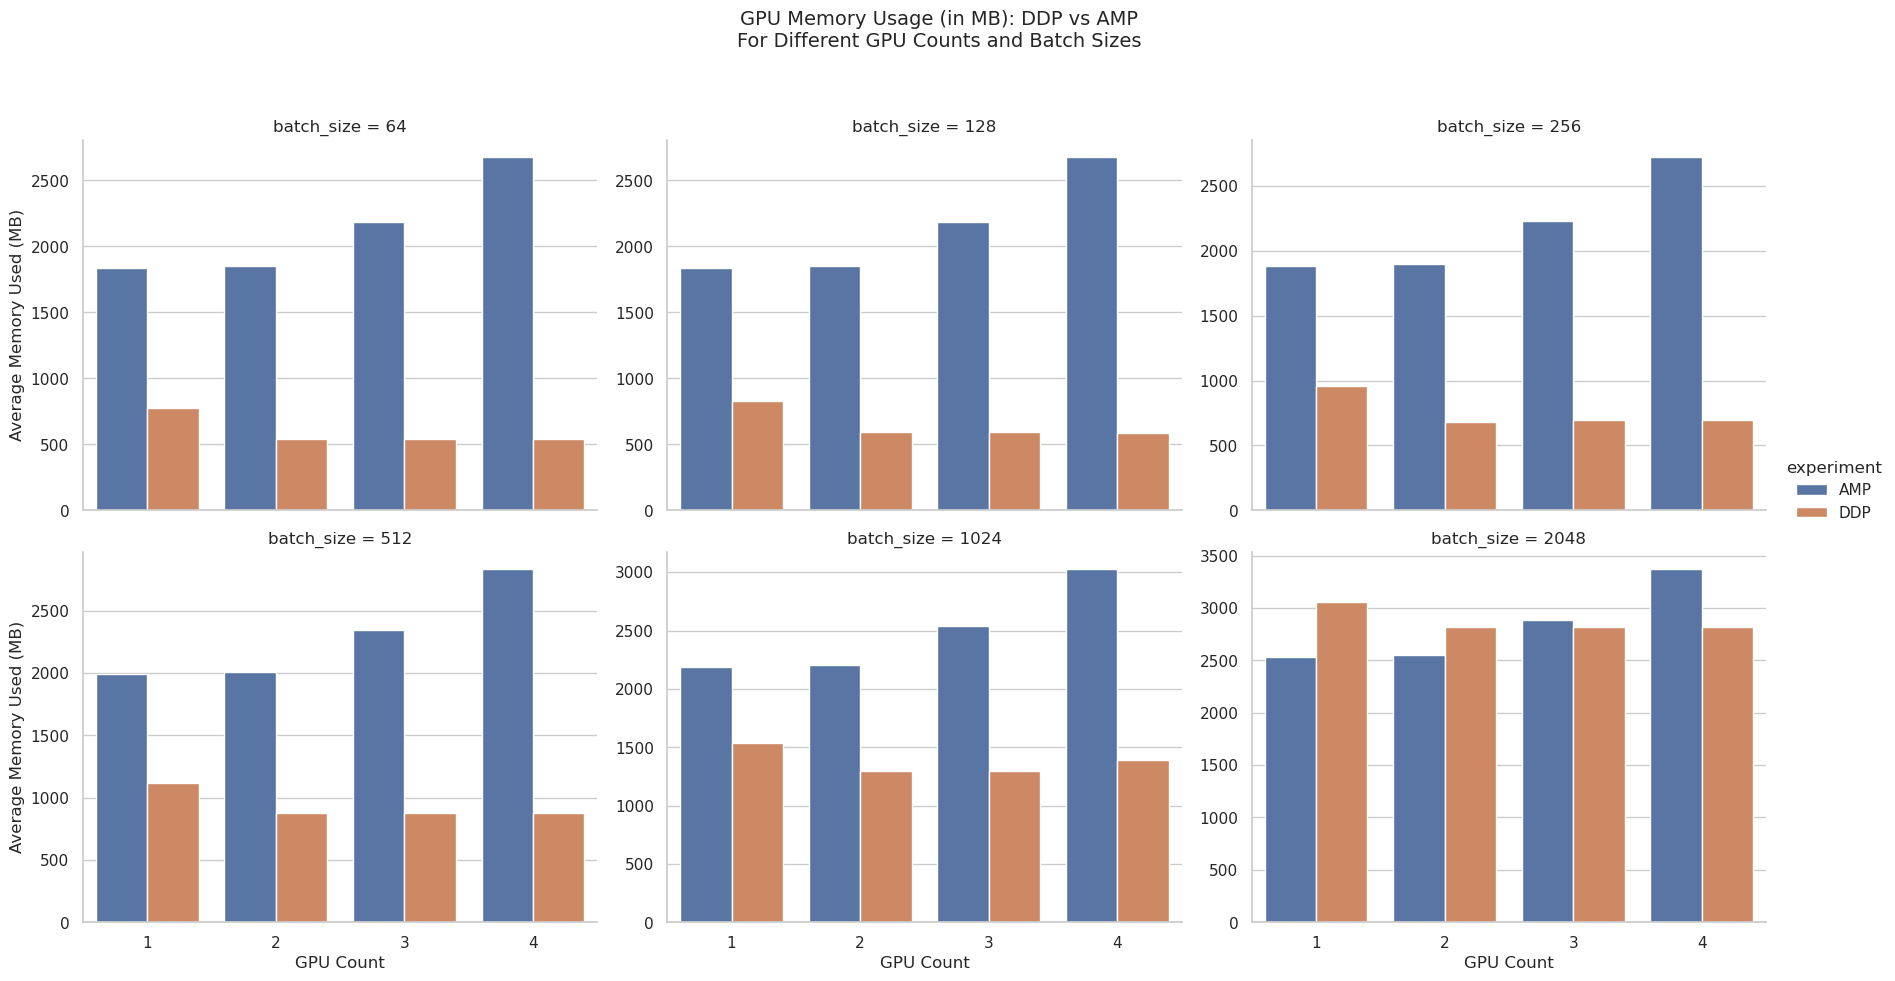

In [9]:
# Make copies if needed (optional)
ddp_df = ddp_metrics_epoch.copy()
amp_df = amp_metrics_epoch.copy()

# Parse each_gpu_memory: remove "MB", convert to float
ddp_df['gpu_memory_total_mb'] = (
    ddp_df['each_gpu_memory']
    .str.replace("MB", "", regex=False)     # remove "MB"
    .astype(float)
)

amp_df['gpu_memory_total_mb'] = (
    amp_df['each_gpu_memory']
    .str.replace("MB", "", regex=False)
    .astype(float)
)

# Convert mem_util (percent) to actual usage in MB
ddp_df['mem_used_mb'] = ddp_df['gpu_memory_total_mb'] * ddp_df['mem_util'] / 100
amp_df['mem_used_mb'] = amp_df['gpu_memory_total_mb'] * amp_df['mem_util'] / 100

# Label each dataset
ddp_df['experiment'] = 'DDP'
amp_df['experiment'] = 'AMP'

# 5️Combine
combined_mem_df = pd.concat([ddp_df, amp_df], ignore_index=True)

# Ensure numeric columns
combined_mem_df['gpu_count'] = pd.to_numeric(combined_mem_df['gpu_count'])
combined_mem_df['batch_size'] = pd.to_numeric(combined_mem_df['batch_size'])
combined_mem_df['mem_used_mb'] = pd.to_numeric(combined_mem_df['mem_used_mb'])

grouped_mem = (
    combined_mem_df
    .groupby(['gpu_count', 'batch_size', 'experiment'], as_index=False)
    .mem_used_mb
    .mean()
    .round(2)  # Round to 2 decimal places for neatness
)

# Pivot the DataFrame so we get separate columns for AMP and DDP
pivot_df = grouped_mem.pivot(
    index=['gpu_count', 'batch_size'],
    columns='experiment',
    values='mem_used_mb'
).reset_index()

# By default, pivot creates a MultiIndex on columns. Let's rename them:
pivot_df.columns.name = None  # Remove the top-level name
pivot_df.rename(
    columns={"AMP": "AMP_Mem_Used_MB", "DDP": "DDP_Mem_Used_MB"},
    inplace=True
)

# Arrange columns in a friendly order
pivot_df = pivot_df[['gpu_count', 'batch_size', 'DDP_Mem_Used_MB', 'AMP_Mem_Used_MB']]
# 1. Create new columns by multiplying per-GPU usage by gpu_count:
pivot_df["DDP_Total_Mem_Used_MB"] = pivot_df["DDP_Mem_Used_MB"] * pivot_df["gpu_count"]
pivot_df["AMP_Total_Mem_Used_MB"] = pivot_df["AMP_Mem_Used_MB"] * pivot_df["gpu_count"]

# 2. Optional: round for neatness
pivot_df["DDP_Total_Mem_Used_MB"] = pivot_df["DDP_Total_Mem_Used_MB"].round(2)
pivot_df["AMP_Total_Mem_Used_MB"] = pivot_df["AMP_Total_Mem_Used_MB"].round(2)
# Display the pivoted result
print("Memory Used (MB) DDP vs AMP")
display(pivot_df)

# 🏷️ Decide which DataFrame to plot:
#    - grouped_mem (average per group)
#    - combined_mem_df (per-epoch data)

plot_data = grouped_mem  # or 'combined_mem_df' if you want raw epoch data

sns.set(style="whitegrid")

g = sns.catplot(
    data=grouped_mem,
    x="gpu_count",
    y="mem_used_mb",
    hue="experiment",
    col="batch_size",
    col_wrap=3,      # 🔑 Use 3 columns in the FacetGrid
    kind="bar",
    height=5,
    aspect=1.2,
    sharey=False
)

g.set_axis_labels("GPU Count", "Average Memory Used (MB)")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("GPU Memory Usage (in MB): DDP vs AMP\nFor Different GPU Counts and Batch Sizes", fontsize=14)

plt.show()

### Key Memory Usage Patterns:

1. **Overall Memory Usage**:
   - Surprisingly, AMP consistently uses **more memory per GPU** than DDP across almost all configurations
   - For batch size 64: DDP uses 778.37MB vs. AMP uses 838.71MB (7.8% more)
   - For batch size 2048: DDP uses 3054.83MB vs. AMP uses 2533.95MB (one exception where AMP uses less)

2. **Scaling with Batch Size**:
   - Both methods show expected increases in memory usage with larger batch sizes
   - DDP memory usage grows by ~3.9× from batch size 64 to 2048 (with 1 GPU)
   - AMP memory usage grows by ~3.0× across the same range

3. **Scaling with GPU Count**:
   - Per-GPU memory usage decreases as GPU count increases for both methods
   - With batch size 2048: DDP memory per GPU drops from 3054.83MB (1 GPU) to 2816.66MB (4 GPUs)
   - AMP shows more dramatic increases in total system memory when scaling to 4 GPUs

## Training Throughput Analysis: DDP vs AMP

Comparison of training throughput (samples processed per second) between standard precision (DDP) and mixed precision (AMP) training across different hardware configurations.

,gpu_count,batch_size,AMP_Throughput,DDP_Throughput,%_Change_Throughput
0,1,64,21885.0,13529.0,62.0
1,1,128,34412.0,17606.0,95.0
2,1,256,47209.0,20788.0,127.0
3,1,512,56359.0,22002.0,156.0
4,1,1024,63166.0,21561.0,193.0
5,1,2048,62269.0,21247.0,193.0
6,2,64,43282.0,25183.0,72.0
7,2,128,65004.0,33377.0,95.0
8,2,256,85166.0,37887.0,125.0
9,2,512,107431.0,41023.0,162.0


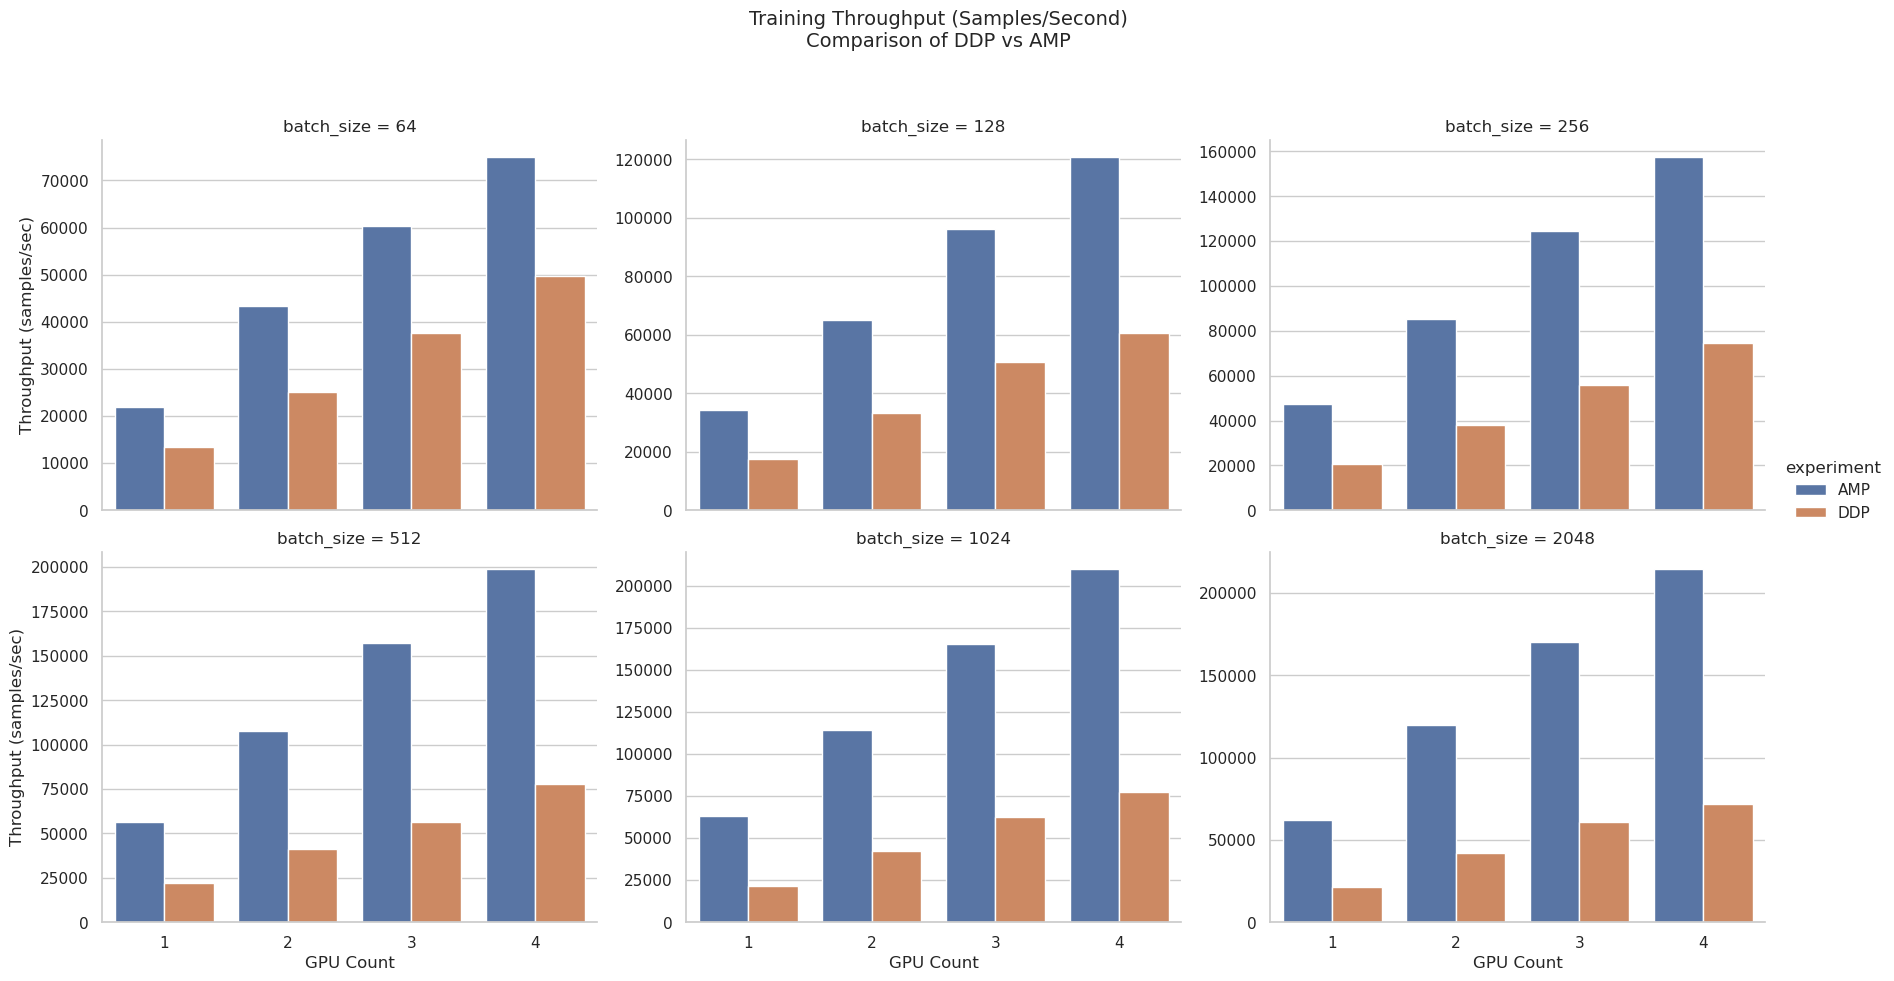

In [22]:
throughput_df = (
    combined_mem_df
    .groupby(['gpu_count', 'batch_size', 'experiment'], as_index=False)['train_throughput']
    .mean()
    .round(0)
)

pivot_throughput = throughput_df.pivot(
    index=["gpu_count", "batch_size"],
    columns="experiment",
    values="train_throughput"
).reset_index()

pivot_throughput.columns.name = None
pivot_throughput.rename(
    columns={
        "DDP": "DDP_Throughput",
        "AMP": "AMP_Throughput"
    },
    inplace=True
)

pivot_throughput['%_Change_Throughput'] = (
    (pivot_throughput['AMP_Throughput'] - pivot_throughput['DDP_Throughput'])
    / pivot_throughput['DDP_Throughput']
) * 100

pivot_throughput['%_Change_Throughput'] = pivot_throughput['%_Change_Throughput'].round()

display(pivot_throughput)

sns.set(style="whitegrid")

g = sns.catplot(
    data=throughput_df,
    x="gpu_count",
    y="train_throughput",
    hue="experiment",
    col="batch_size",
    col_wrap=3,      # 3 columns for the FacetGrid
    kind="bar",
    height=5,
    aspect=1.2,
    sharey=False
)

g.set_axis_labels("GPU Count", "Throughput (samples/sec)")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Training Throughput (Samples/Second)\nComparison of DDP vs AMP", fontsize=14)

plt.show()

Dramatic Performance Improvements with Mixed Precision Training!!

1. **Consistent Performance Advantage**:
   - AMP dramatically outperforms DDP across all configurations
   - The performance gap widens with increasing batch size and GPU count
   - With 1 GPU and batch size 64: AMP processes 21,885 samples/sec vs DDP's 13,529 samples/sec (62% improvement)

2. **Scaling Characteristics**:
   - Both methods show good scaling with additional GPUs, but AMP scales more efficiently
   - At batch size 512: AMP throughput reaches 198,720 samples/sec with 4 GPUs (3.5× the throughput of 1 GPU)
   - The highest throughput achieved is 214,423 samples/sec (AMP, 4 GPUs, batch size 2048)

3. **Batch Size Impact**:
   - Larger batch sizes yield higher throughput for both methods
   - AMP shows more dramatic throughput increases with larger batches
   - With 4 GPUs, batch size 2048: AMP delivers a staggering 199% improvement over DDP

4. **Exponential Improvements**:
   - The percentage advantage of AMP over DDP increases with configuration complexity:
     - Small configurations (1-2 GPUs, batch sizes 64-128): 60-95% improvement
     - Medium configurations (2-3 GPUs, batch sizes 256-512): 120-180% improvement
     - Large configurations (3-4 GPUs, batch sizes 1024-2048): 160-199% improvement